<a href="https://www.kaggle.com/code/caitlinruble/melanoma-detection-using-fastai-on-resnet34-base?scriptVersionId=108388236" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


This notebook holds the best model I've devised.
Current metrics include:

**Cross Validation Scores:**

mean_roc_auc_CV = 0.885 \
mean_error_rate_CV = 0.201 \
mean_precision_CV = 0.793 \
mean_recall_CV = 0.812 \


**Private Validation on Unseen Test Data:** 

Validation Set Precision: 0.83 \
Validation Set Recall: 0.83 \
Validation Set Accuracy: 0.83 \
Validation Set Average Precision Score: 0.9 \
Validation Set Roc Auc Score: 0.9

**Kaggle Competition ROCAUC Leaderboard Scores:**

Private: 0.8531
Public: 0.8702


Notebook Contents:

1. Model scores
2. Model file names
3. Setting up environment
4. Preparing data for training, testing and validation
5. Modeling and predictions
6. Model Evaluation

## Import Libraries

In [24]:
#hide output
!pip install -Uqq fastbook --q --q
!pip install ipywidgets

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import imageio.v2 as imageio

sns.set_style('darkgrid')
plt.style.use('seaborn-notebook')

import fastbook
fastbook.setup_book()
import fastai

import random
random.seed(42)

from fastbook import *
from fastai.vision.all import *
import torch
from pathlib import Path
from PIL import Image

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import *
import statistics

In [26]:
#set device and ensure GPU is running
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Preparation
1. Load metadata csv files, 
2. select all the malignant images, then downsample the benign category in remaining training data so n_malignant = n_benign for training, 
3. split off 20% of training data as a validation set, 
4. then create a 5-fold split of what remains for cross-validation in model training

In [27]:
#1. Load metadata .csv files

#read in train csv
train = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')

#read in test csv
test = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')

In [28]:
#Step 2: select all the malignant images, then downsample the benign category in remaining training data so n_malignant = n_benign for training

#split train_ims into 5 sets using StratifiedKFold from sklearn
#create a df with ALL of the malignant images
mal_ims = train[train['target']==1]
n_mal_ims = len(mal_ims)
print("Number of malignant images: {}".format(n_mal_ims))
mal_ims.head()

#create a df of a subset of benevolent images
ben_ims_subset = train[train['target']==0].sample(n=n_mal_ims, random_state=42)
n_ben_ims = len(ben_ims_subset)
print("Number of benign images in subset: {}".format(n_ben_ims))

#concatenate the two together and check the result
train_ims = pd.concat([mal_ims, ben_ims_subset])
n_training_items = len(train_ims)
print("Number of training items: {}".format(n_training_items))

#add /train prefix and /test prefix to the respective dfs
train_ims['image_name'] = 'train/' + train_ims['image_name'].astype(str)
test['image_name'] = 'test/' + test['image_name'].astype(str)

train_ims.reset_index(drop=True, inplace=True)
train_ims.head()

Number of malignant images: 584
Number of benign images in subset: 584
Number of training items: 1168


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,train/ISIC_0149568,IP_0962375,female,55.0,upper extremity,melanoma,malignant,1
1,train/ISIC_0188432,IP_0135517,female,50.0,upper extremity,melanoma,malignant,1
2,train/ISIC_0207268,IP_7735373,male,55.0,torso,melanoma,malignant,1
3,train/ISIC_0232101,IP_8349964,male,65.0,torso,melanoma,malignant,1
4,train/ISIC_0247330,IP_3232631,female,65.0,lower extremity,melanoma,malignant,1


In [29]:
#Step 3: split off 20% of training data as a validation set,

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = train_ims['image_name'].copy()
y = train_ims['target'].copy()
fold = 0
for train_index, test_index in skf.split(X, y):
    fold+= 1
    print('In fold',fold)
    print("TRAIN LENGTH:", len(train_index), "VALIDATION LENGTH:", len(test_index))
    train_ims[f'fold_{fold}_valid']=False
    train_ims.loc[test_index,f'fold_{fold}_valid']=True
    

#Pull out 20% of entries to be held out as unseen test data for validation.
valid_ims = train_ims[train_ims['fold_5_valid'] == True]

valid_ims.reset_index(drop=True, inplace=True)
valid_ims.head()


In fold 1
TRAIN LENGTH: 934 VALIDATION LENGTH: 234
In fold 2
TRAIN LENGTH: 934 VALIDATION LENGTH: 234
In fold 3
TRAIN LENGTH: 934 VALIDATION LENGTH: 234
In fold 4
TRAIN LENGTH: 935 VALIDATION LENGTH: 233
In fold 5
TRAIN LENGTH: 935 VALIDATION LENGTH: 233


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,fold_1_valid,fold_2_valid,fold_3_valid,fold_4_valid,fold_5_valid
0,train/ISIC_0232101,IP_8349964,male,65.0,torso,melanoma,malignant,1,False,False,False,False,True
1,train/ISIC_0247330,IP_3232631,female,65.0,lower extremity,melanoma,malignant,1,False,False,False,False,True
2,train/ISIC_0280912,IP_5831170,male,70.0,torso,melanoma,malignant,1,False,False,False,False,True
3,train/ISIC_0327406,IP_7069391,male,40.0,upper extremity,melanoma,malignant,1,False,False,False,False,True
4,train/ISIC_0502582,IP_9175987,male,65.0,lower extremity,melanoma,malignant,1,False,False,False,False,True


In [30]:
#Step 4: create a 5-fold split of what remains for cross-validation in model training

#drop the test set from train_ims, then split the remaining images into 5 folds for cross-validation during model training
train_ims = train_ims[train_ims['fold_5_valid'] == False]
train_ims = train_ims[['image_name','patient_id','sex','age_approx','anatom_site_general_challenge','diagnosis','benign_malignant','target']]
train_ims.reset_index(drop=True, inplace=True)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = train_ims['image_name'].copy()
y = train_ims['target'].copy()
fold = 0
for train_index, test_index in skf.split(X, y):
    fold+= 1
    print('In fold',fold)
    print("TRAIN LENGTH:", len(train_index), "VALIDATION LENGTH:", len(test_index))
    train_ims[f'fold_{fold}_valid']=False
    train_ims.loc[test_index,f'fold_{fold}_valid']=True
    
train_ims.head()

In fold 1
TRAIN LENGTH: 748 VALIDATION LENGTH: 187
In fold 2
TRAIN LENGTH: 748 VALIDATION LENGTH: 187
In fold 3
TRAIN LENGTH: 748 VALIDATION LENGTH: 187
In fold 4
TRAIN LENGTH: 748 VALIDATION LENGTH: 187
In fold 5
TRAIN LENGTH: 748 VALIDATION LENGTH: 187


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,fold_1_valid,fold_2_valid,fold_3_valid,fold_4_valid,fold_5_valid
0,train/ISIC_0149568,IP_0962375,female,55.0,upper extremity,melanoma,malignant,1,True,False,False,False,False
1,train/ISIC_0188432,IP_0135517,female,50.0,upper extremity,melanoma,malignant,1,True,False,False,False,False
2,train/ISIC_0207268,IP_7735373,male,55.0,torso,melanoma,malignant,1,True,False,False,False,False
3,train/ISIC_0250839,IP_6234053,male,75.0,head/neck,melanoma,malignant,1,False,False,False,True,False
4,train/ISIC_0272509,IP_0408084,female,35.0,lower extremity,melanoma,malignant,1,True,False,False,False,False


In [31]:
#check for any overlap between the train_ims df and valid_ims df

idx1 = pd.Index(train_ims['image_name'])
idx2 = pd.Index(valid_ims['image_name'])
idx1.intersection(idx2)

Index([], dtype='object', name='image_name')

## Set up dataloader, CV training loop, and store results

In [32]:
def dataloader(fold, bs=8, b_tfms=Normalize.from_stats(*imagenet_stats)):
    dls = ImageDataLoaders.from_df(df = train_ims, #specify df holding image names
                                   path = '../input/siic-isic-224x224-images',    #set path for where to find images
                                   suff = '.png',      #add the .png suffix to file names from df
                                   label_col = 'target',      
                                   bs = bs,            #set batch size
                                   device=device,      #set device
                                   batch_tfms = b_tfms,
                                   valid_col = f'fold_{fold}_valid')
    return dls
    

In [33]:
#instantiate metrics
rocAucBinary = RocAucBinary()
recall = Recall()
precision = Precision()

#instantiate arrays to hold probability results
valid_preds = np.zeros((valid_ims.shape[0],2))
kaggle_preds = np.zeros((test.shape[0],2))

#choose batch transforms, batch size, and the name of 
b_tfms = [#*aug_transforms(do_flip=True, flip_vert=True, max_rotate=45.0, max_zoom=1.1, size=224, max_lighting=0.2, max_warp=0.4, p_affine=0.75, p_lighting=0.75, xtra_tfms=None, mode='bilinear'),
          Normalize.from_stats(*imagenet_stats)]
batch_size=8

for fold in range(1,6):
    dls=dataloader(fold, batch_size, b_tfms)
    print(f'Fold {fold}:')
    learn = vision_learner(dls,                  #specify dataloader object
                       models.resnet34,             #specify a pre-trained model we want to build off of
                       metrics=[rocAucBinary, error_rate, precision, recall], #specify metrics we want to see
                       model_dir = '/kaggle/working')   #specify output location to store model
    
    learn.fine_tune(15,                               #set number of epochs 
                 #base_lr=valley,                  #set the initial learning rate
                 cbs=[SaveModelCallback(            #use the SaveModelCallback to save the best model
                     monitor='roc_auc_score',      #set the roc_auc_score as the montitored metric
                     fname = f'resnet34_rocauc_fold{fold}',       #choose the name the best model will be saved under
                     comp = np.greater,            #specify that when the roc_auc_score increases, that's considered better
                     with_opt=True),               #saves optimizer state, if available, when saving model
                    ReduceLROnPlateau(monitor = 'roc_auc_score', comp = np.greater, patience=2)])
                   # EarlyStoppingCallback(monitor = 'roc_auc_score', comp=np.greater, patience=6)])
    
    learn.load(f'resnet34_rocauc_fold{fold}', 
               device=device,     #ensure the loaded model uses the active cuda:0 device
               with_opt=True,     #load optimizer state
               strict=True)
    
    test_dl = learn.dls.test_dl(valid_ims)
    preds, _ = learn.tta(dl=test_dl) 
    valid_preds += preds.numpy()
    
    kag_dl = learn.dls.test_dl(test)
    preds, _ = learn.get_preds(dl=kag_dl) 
    kaggle_preds += preds.numpy()
    
    print(f'Prediction completed in fold: {fold}')

    fold+=1

kaggle_pred = kaggle_preds/5
valid_preds = valid_preds/5

Fold 1:


epoch,train_loss,valid_loss,roc_auc_score,error_rate,precision_score,recall_score,time
0,1.028198,1.046933,0.752345,0.283422,0.702970,0.755319,00:09


Better model found at epoch 0 with roc_auc_score value: 0.752345001143903.


epoch,train_loss,valid_loss,roc_auc_score,error_rate,precision_score,recall_score,time
0,0.761793,0.827812,0.777740,0.278075,0.723404,0.723404,00:10
1,0.604652,0.800916,0.791352,0.288770,0.708333,0.723404,00:11
2,0.600560,0.755618,0.835964,0.235294,0.765957,0.765957,00:09
3,0.616633,0.580034,0.863304,0.192513,0.845238,0.755319,00:10
4,0.508367,0.716626,0.800732,0.251337,0.797468,0.670213,00:11
5,0.434546,0.634827,0.838023,0.208556,0.761905,0.851064,00:10
6,0.276205,0.661600,0.853695,0.213904,0.800000,0.765957,00:10
7,0.263288,0.612221,0.857927,0.219251,0.773196,0.797872,00:11
8,0.235723,0.594724,0.869938,0.213904,0.829268,0.723404,00:10
9,0.197796,0.541907,0.892588,0.181818,0.875000,0.744681,00:10


Better model found at epoch 0 with roc_auc_score value: 0.777739647677877.
Better model found at epoch 1 with roc_auc_score value: 0.7913520933424846.
Better model found at epoch 2 with roc_auc_score value: 0.8359643102264928.
Better model found at epoch 3 with roc_auc_score value: 0.8633035918554107.
Epoch 5: reducing lr to 9.511805614958973e-05
Epoch 7: reducing lr to 7.513942659942228e-05
Better model found at epoch 8 with roc_auc_score value: 0.8699382292381606.
Better model found at epoch 9 with roc_auc_score value: 0.8925875085792725.
Better model found at epoch 10 with roc_auc_score value: 0.893273850377488.
Epoch 12: reducing lr to 8.779801865374439e-06
Epoch 14: reducing lr to 1.2587570077200392e-09


Prediction completed in fold: 1
Fold 2:


epoch,train_loss,valid_loss,roc_auc_score,error_rate,precision_score,recall_score,time
0,1.050803,0.982882,0.762411,0.299465,0.715909,0.670213,00:09


Better model found at epoch 0 with roc_auc_score value: 0.7624113475177305.


epoch,train_loss,valid_loss,roc_auc_score,error_rate,precision_score,recall_score,time
0,0.848349,0.576543,0.831503,0.262032,0.731959,0.755319,00:10
1,0.670314,0.596745,0.846717,0.213904,0.764706,0.829787,00:10
2,0.627228,0.820654,0.810455,0.294118,0.760000,0.606383,00:10
3,0.555950,0.597840,0.855639,0.219251,0.773196,0.797872,00:10
4,0.445615,0.665566,0.823953,0.224599,0.754902,0.819149,00:10
5,0.395696,0.765087,0.827156,0.262032,0.710280,0.808511,00:11
6,0.277364,0.565116,0.868794,0.192513,0.802083,0.819149,00:10
7,0.258165,0.697518,0.846374,0.229947,0.747573,0.819149,00:10
8,0.227641,0.514706,0.887440,0.213904,0.813953,0.744681,00:10
9,0.231960,0.553171,0.886754,0.208556,0.857143,0.702128,00:10


Better model found at epoch 0 with roc_auc_score value: 0.831503088538092.
Better model found at epoch 1 with roc_auc_score value: 0.8467169983985358.
Better model found at epoch 3 with roc_auc_score value: 0.8556394417753374.
Epoch 5: reducing lr to 9.511805614958973e-05
Better model found at epoch 6 with roc_auc_score value: 0.8687943262411347.
Better model found at epoch 8 with roc_auc_score value: 0.8874399450926561.
Epoch 10: reducing lr to 3.188347010650552e-05
Epoch 12: reducing lr to 8.779801865374439e-06
Epoch 14: reducing lr to 1.2587570077200392e-09


Prediction completed in fold: 2
Fold 3:


epoch,train_loss,valid_loss,roc_auc_score,error_rate,precision_score,recall_score,time
0,1.073306,0.941367,0.750286,0.315508,0.680412,0.702128,00:09


Better model found at epoch 0 with roc_auc_score value: 0.7502859757492564.


epoch,train_loss,valid_loss,roc_auc_score,error_rate,precision_score,recall_score,time
0,0.745433,0.656675,0.823381,0.267380,0.739130,0.723404,00:10
1,0.600412,0.815907,0.790094,0.278075,0.718750,0.734043,00:11
2,0.505894,0.686661,0.836651,0.235294,0.755102,0.787234,00:11
3,0.495357,0.865129,0.778998,0.299465,0.686275,0.744681,00:09
4,0.492301,0.833246,0.791924,0.267380,0.720000,0.765957,00:11
5,0.490272,0.647141,0.839968,0.240642,0.752577,0.776596,00:10
6,0.321108,0.583187,0.870625,0.192513,0.763636,0.893617,00:11
7,0.252958,0.616464,0.873599,0.208556,0.772277,0.829787,00:11
8,0.261136,0.629099,0.865820,0.213904,0.821429,0.734043,00:10
9,0.189626,0.611325,0.866049,0.203209,0.797872,0.797872,00:10


Better model found at epoch 0 with roc_auc_score value: 0.8233813772592085.
Better model found at epoch 2 with roc_auc_score value: 0.8366506520247083.
Epoch 4: reducing lr to 9.94652663688326e-05
Better model found at epoch 5 with roc_auc_score value: 0.8399679707160832.
Better model found at epoch 6 with roc_auc_score value: 0.8706245710363761.
Better model found at epoch 7 with roc_auc_score value: 0.8735987188286434.
Epoch 9: reducing lr to 4.642446536726715e-05
Better model found at epoch 11 with roc_auc_score value: 0.8796614047128803.
Epoch 13: reducing lr to 2.2699982928197543e-06


Prediction completed in fold: 3
Fold 4:


epoch,train_loss,valid_loss,roc_auc_score,error_rate,precision_score,recall_score,time
0,1.145575,0.888908,0.759437,0.336898,0.674419,0.623656,00:09


Better model found at epoch 0 with roc_auc_score value: 0.7594371997254633.


epoch,train_loss,valid_loss,roc_auc_score,error_rate,precision_score,recall_score,time
0,0.828963,0.573796,0.851865,0.240642,0.740000,0.795699,00:11
1,0.621266,0.584160,0.855754,0.219251,0.750000,0.838710,00:11
2,0.531105,0.821825,0.830588,0.229947,0.745098,0.817204,00:10
3,0.612182,0.856956,0.784489,0.267380,0.779221,0.645161,00:11
4,0.458662,0.827173,0.831617,0.240642,0.750000,0.774194,00:10
5,0.367106,0.848543,0.820636,0.235294,0.775281,0.741935,00:11
6,0.316937,0.749767,0.831160,0.262032,0.744444,0.720430,00:11
7,0.305529,0.600411,0.845802,0.208556,0.806818,0.763441,00:10
8,0.299366,0.797098,0.814573,0.229947,0.731481,0.849462,00:11
9,0.189170,0.640402,0.864791,0.219251,0.776596,0.784946,00:09


Better model found at epoch 0 with roc_auc_score value: 0.8518645618851521.
Better model found at epoch 1 with roc_auc_score value: 0.8557538320750401.
Epoch 3: reducing lr to 9.748394524683107e-05
Epoch 5: reducing lr to 9.511805614958973e-05
Epoch 7: reducing lr to 7.513942659942228e-05
Better model found at epoch 9 with roc_auc_score value: 0.8647906657515443.
Better model found at epoch 10 with roc_auc_score value: 0.8800045756119882.
Better model found at epoch 11 with roc_auc_score value: 0.8828643331045527.
Epoch 13: reducing lr to 2.2699982928197543e-06


Prediction completed in fold: 4
Fold 5:


epoch,train_loss,valid_loss,roc_auc_score,error_rate,precision_score,recall_score,time
0,1.073561,0.946162,0.762183,0.310160,0.705882,0.645161,00:09


Better model found at epoch 0 with roc_auc_score value: 0.7621825669183254.


epoch,train_loss,valid_loss,roc_auc_score,error_rate,precision_score,recall_score,time
0,0.885956,0.765734,0.797529,0.278075,0.725275,0.709677,00:09
1,0.657085,0.860436,0.787120,0.278075,0.741176,0.677419,00:10
2,0.533399,0.750763,0.826012,0.235294,0.769231,0.752688,00:11
3,0.540417,0.753509,0.831617,0.245989,0.752688,0.752688,00:10
4,0.430889,0.863558,0.791924,0.294118,0.702128,0.709677,00:08
5,0.406671,0.591080,0.844200,0.262032,0.724490,0.763441,00:10
6,0.282997,0.731034,0.822123,0.251337,0.761364,0.720430,00:10
7,0.243372,0.635139,0.841341,0.256684,0.747253,0.731183,00:10
8,0.205314,0.699425,0.833677,0.267380,0.794521,0.623656,00:10
9,0.196892,0.634331,0.849920,0.262032,0.739130,0.731183,00:09


Better model found at epoch 0 with roc_auc_score value: 0.797529169526424.
Better model found at epoch 2 with roc_auc_score value: 0.8260123541523678.
Better model found at epoch 3 with roc_auc_score value: 0.8316174788377945.
Better model found at epoch 5 with roc_auc_score value: 0.844200411805079.
Epoch 7: reducing lr to 7.513942659942228e-05
Better model found at epoch 9 with roc_auc_score value: 0.8499199267902082.
Better model found at epoch 10 with roc_auc_score value: 0.863761153054221.
Better model found at epoch 11 with roc_auc_score value: 0.8669640814458934.
Better model found at epoch 12 with roc_auc_score value: 0.8741706703271563.
Better model found at epoch 13 with roc_auc_score value: 0.8817204301075269.


Prediction completed in fold: 5


In [43]:
fold_1_metrics=[0.893274,0.203209,0.785714,0.819149]
fold_2_metrics=[0.887440,0.213904,0.813953,0.744681]
fold_3_metrics=[0.879661,0.187166,0.775701,0.882979]
fold_4_metrics=[0.882864,0.208556,0.787234,0.795699]
fold_5_metrics=[0.881720,0.192513,0.800000,0.817204]

mean_roc_auc = statistics.mean([fold_1_metrics[0],fold_2_metrics[0],fold_3_metrics[0],fold_4_metrics[0],fold_5_metrics[0]])
mean_error = statistics.mean([fold_1_metrics[1],fold_2_metrics[1],fold_3_metrics[1],fold_4_metrics[1],fold_5_metrics[1]])
mean_precision = statistics.mean([fold_1_metrics[2],fold_2_metrics[2],fold_3_metrics[2],fold_4_metrics[2],fold_5_metrics[2]])
mean_recall = statistics.mean([fold_1_metrics[3],fold_2_metrics[3],fold_3_metrics[3],fold_4_metrics[3],fold_5_metrics[3]])

print(f'mean_roc_auc_CV = {np.round(mean_roc_auc,3)}')
print(f'mean_error_rate_CV = {np.round(mean_error,3)}')
print(f'mean_precision_CV = {np.round(mean_precision,3)}')
print(f'mean_recall_CV = {np.round(mean_recall,3)}')




mean_roc_auc_CV = 0.885
mean_error_rate_CV = 0.201
mean_precision_CV = 0.793
mean_recall_CV = 0.812


## Interpret Results

In [35]:
ss = pd.read_csv('../input/siim-isic-melanoma-classification/sample_submission.csv')

#Save kaggle predictions to csv for submission
sub_file_name="submission_resnet34_Oct172022_rocauc_opt.csv"
submission = pd.DataFrame({'image_name':ss['image_name'], 'target':list(kaggle_preds[:,1])})
submission.to_csv(sub_file_name, index=False)

### Kaggle Submission ROC_AUC_scores:
**Private:** 0.8531

**Public:** 0.8702






In [36]:
#transfer averaged CV results into a DataFrame for visualization and to calculate the relevent metrics
test_res = pd.DataFrame({'image_name':valid_ims['image_name'], 'true_label':valid_ims['target'] ,'target_preds':list(valid_preds[:,1])})

#assign class predictions based on a prediction threshold of 0.5
test_res['pred_label'] = np.where(test_res['target_preds'] >= .5, 1, 0)


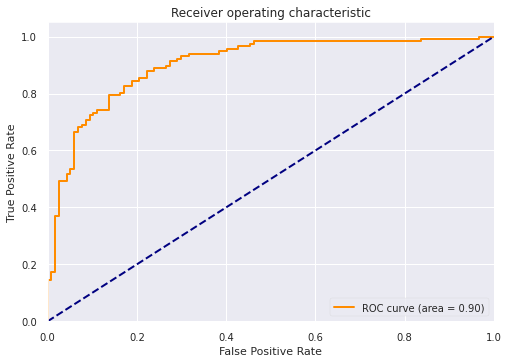

In [44]:
#visualize ROC for validation data
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(test_res['true_label'], test_res['target_preds'])
roc_auc = auc(fpr, tpr)

#plot Reciever Operating Characteristic
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

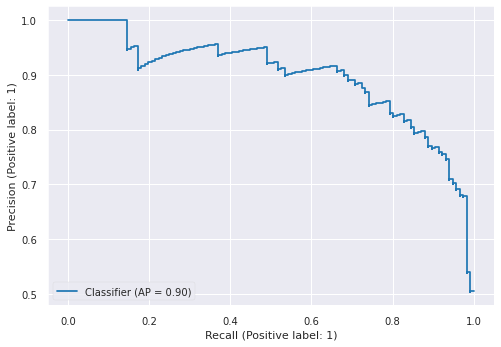

In [45]:
#Generate and Plot Precision Recall Curve
from sklearn.metrics import PrecisionRecallDisplay
ax1 = PrecisionRecallDisplay.from_predictions(test_res['true_label'], test_res['target_preds'])
plt.show()

Validation Set Precision: 0.83
Validation Set Recall: 0.83
Validation Set Accuracy: 0.83
Validation Set Average Precision Score: 0.9
Validation Set Roc Auc Score: 0.9
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       117
           1       0.83      0.83      0.83       116

    accuracy                           0.83       233
   macro avg       0.83      0.83      0.83       233
weighted avg       0.83      0.83      0.83       233



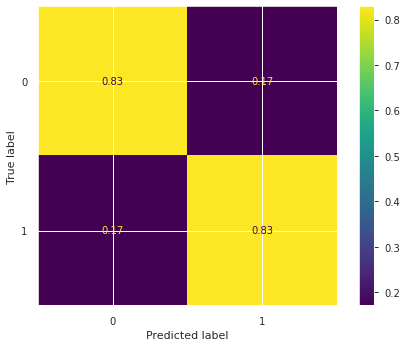

In [46]:
test_set_precision = precision_score(test_res['true_label'], test_res['pred_label'])
test_set_recall = recall_score(test_res['true_label'], test_res['pred_label'])
test_set_accuracy = accuracy_score(test_res['true_label'], test_res['pred_label'])
test_set_average_precision = average_precision_score(test_res['true_label'], test_res['target_preds'])
test_set_auroc = roc_auc_score(test_res['true_label'], test_res['target_preds'])

print(f'Validation Set Precision: {np.round(test_set_precision,2)}')
print(f'Validation Set Recall: {np.round(test_set_recall,2)}')
print(f'Validation Set Accuracy: {np.round(test_set_accuracy,2)}')

print(f'Validation Set Average Precision Score: {np.round(test_set_average_precision,2)}')
print(f'Validation Set Roc Auc Score: {np.round(test_set_auroc,2)}')

print(classification_report(test_res['true_label'], test_res['pred_label']))
    
ConfusionMatrixDisplay.from_predictions(test_res['true_label'], test_res['pred_label'], normalize='true')

### Export best models for future deployment

In [47]:
for fold in range(1,6):
    learn.load(f'resnet34_rocauc_fold{fold}', 
               device=device,     #ensure the loaded model uses the active cuda:0 device
               with_opt=True,     #load optimizer state
               strict=True)
    learn.export(f'/kaggle/working/melanoma_detector_fold{fold}.pkl')